In [1]:
import pyam
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Step 1: Read in the necessary data. This is prepared in the notebook `101_prepare_input_data.ipynb`

In [3]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


<IPython.core.display.Javascript object>

Step 2: Pull out the net CO2 emission (direct) estimates from the scenarios and calculate the offset from the year 2020.

In [4]:
net_emissions_world = (
    df
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
        year=range(2020, 2101),
        region='World'
    )
    .offset(year=2020)
    .timeseries()
)

<IPython.core.display.Javascript object>

Step 3: We now want to have the corresponding 2020 values. We can divide the offset estimates with this 2020 value to get the % reduction.

In [5]:
net_emissions_world_2020 = (
    df
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
        year=2020,
        region='World'
    )
    .timeseries()
)

<IPython.core.display.Javascript object>

In [6]:
percentage_below = (
    net_emissions_world.apply(
        lambda x: x * 100 / net_emissions_world_2020.loc[x.name, 2020],
        axis=1
    )
)

<IPython.core.display.Javascript object>

Step 4: Per scenario, we now want to identify the first year when we achieve the 50% below threshold.

In [7]:
first_year_below_50 = pd.DataFrame(
    percentage_below
    .apply(
        lambda x: x[x<=-50].index.min(),
        axis=1
    )
)

<IPython.core.display.Javascript object>

In [8]:
first_year_below_50.rename(
    columns={
        0:'first_year_50_perc'
    },
    inplace=True
)

<IPython.core.display.Javascript object>

In [9]:
first_year_below_50.loc[:,'first_year_50_perc_from_2020'] = first_year_below_50.loc[:,'first_year_50_perc'] - 2020

<IPython.core.display.Javascript object>

Step 5: Let us look at the data and then bin them into different categories based on the years until 50% reductions are achieved.

Text(0.5, 0, 'First year when 50% net emission reductions are achieved')

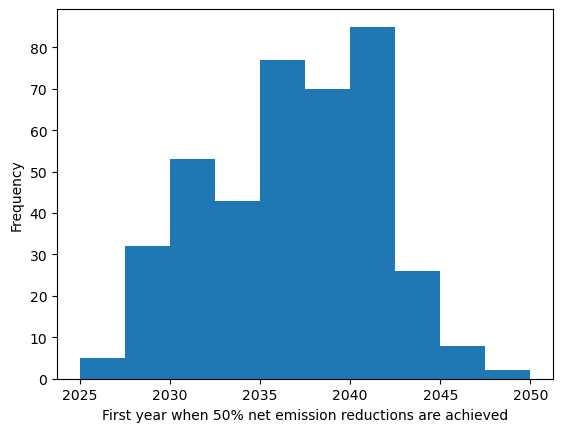

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots()

first_year_below_50['first_year_50_perc'].plot(kind='hist', ax=ax)

ax.set_xlabel('First year when 50% net emission reductions are achieved')

In [11]:
bins_for_reductions = pd.IntervalIndex.from_tuples(
    [
        (0,10),
        (10, 20),
        (20, 30)
    ]
)

<IPython.core.display.Javascript object>

In [12]:
bin_maps = dict(
    zip(
        bins_for_reductions,
        #['0-10','10-20','20-30'],
        ['2020-2030', '2030-2040', '2040-2050']
    )
)

<IPython.core.display.Javascript object>

In [13]:
first_year_below_50.loc[:, 'category_reductions'] = (
    pd.cut(
        first_year_below_50['first_year_50_perc_from_2020'],
        bins=bins_for_reductions, 
    )
    .map(bin_maps)
)

<IPython.core.display.Javascript object>

Step 6: Drop the additional columns so that we can use this as a somewhat generalised metadata frame

In [14]:
category_meta = first_year_below_50.droplevel(
    [
        'region',
        'variable',
        'unit'
    ]
)

<IPython.core.display.Javascript object>

Step 7: Now, we want to do something similar for the global year of net zero (harmonised).

In [15]:
bins_net_zero = pd.IntervalIndex.from_tuples(
    [
        (0,30),
        (30, 55),
        (55,80)
    ]
)

<IPython.core.display.Javascript object>

In [16]:
category_meta.loc[:,'time_until_netzero'] = (
    df.meta.loc[:,'Year of netzero CO2 emissions (Harm-Infilled) table']
    -
    2020
)

<IPython.core.display.Javascript object>

Step 8: There are some NaN. How many, and should we fill this in with 2100?

In [17]:
category_meta.isna().nunique()

first_year_50_perc              1
first_year_50_perc_from_2020    1
category_reductions             1
time_until_netzero              1
dtype: int64

<IPython.core.display.Javascript object>

In [18]:
category_meta.fillna(80, inplace=True)

<IPython.core.display.Javascript object>

Step 9: Create a similar set of bin maps.

In [19]:
bin_maps = dict(
    zip(
        bins_net_zero,
        #['0-30', '30-55', '55-80']
        ['2020-2050', '2050-2075', '2075-2100']
    )
)

<IPython.core.display.Javascript object>

Step 10: Construct the new bins.

In [20]:
category_meta.loc[:,'category_netzero']=(
    pd
    .cut(
        category_meta['time_until_netzero'],
        bins=bins_net_zero
    )
    .map(bin_maps)
)

<IPython.core.display.Javascript object>

In [21]:
(
    category_meta
    .groupby(['category_netzero', 'category_reductions'])['first_year_50_perc']
    .count()
    .unstack()
)

category_reductions,2020-2030,2030-2040,2040-2050
category_netzero,,,
2020-2050,17,33,0
2050-2075,35,166,66
2075-2100,4,55,25


<IPython.core.display.Javascript object>

Step 11: Save out this data for use in figure 1

In [22]:
category_meta.to_excel(
    Path(
        '../data/102_delay_categories.xlsx'
    ),
    merge_cells=False
)

<IPython.core.display.Javascript object>